In [ ]:
from google.colab import files
uploaded = files.upload()  # upload the CSV

Saving Wednesday-workingHours.pcap_ISCX.csv to Wednesday-workingHours.pcap_ISCX.csv


In [ ]:
# Reload the full CSV without filtering first
df = pd.read_csv("Wednesday-workingHours.pcap_ISCX.csv")
df.columns = df.columns.str.strip()

# Show all unique attack types and how many samples of each
print(df['Label'].value_counts())

Label
BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64


In [ ]:
df = df[df['Label'].isin([
    'BENIGN',
    'DoS Hulk',
    'DoS GoldenEye',
    'DoS slowloris',
    'DoS Slowhttptest'
])]

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

df = df.replace([np.inf, -np.inf], np.nan).dropna()
X = df.drop('Label', axis=1)
y = df['Label']

# Encode multiclass labels: e.g., BENIGN=0, Hulk=1, etc.
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))

# Train RF
rf = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
start_rf = time.time()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
end_rf = time.time()
print(f"Random Forest runtime: {end_rf - start_rf:.2f} seconds")
evaluate_model("Random Forest", y_test, rf_preds)


Random Forest runtime: 217.35 seconds

Random Forest Results:
Confusion Matrix:
 [[87886     0    48     2     0]
 [    7  2047     4     1     0]
 [    7     4 46014     0     0]
 [    3     0     0  1090     7]
 [    6     0     1     4  1148]]
Classification Report:
                   precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00     87936
   DoS GoldenEye       1.00      0.99      1.00      2059
        DoS Hulk       1.00      1.00      1.00     46025
DoS Slowhttptest       0.99      0.99      0.99      1100
   DoS slowloris       0.99      0.99      0.99      1159

        accuracy                           1.00    138279
       macro avg       1.00      0.99      1.00    138279
    weighted avg       1.00      1.00      1.00    138279



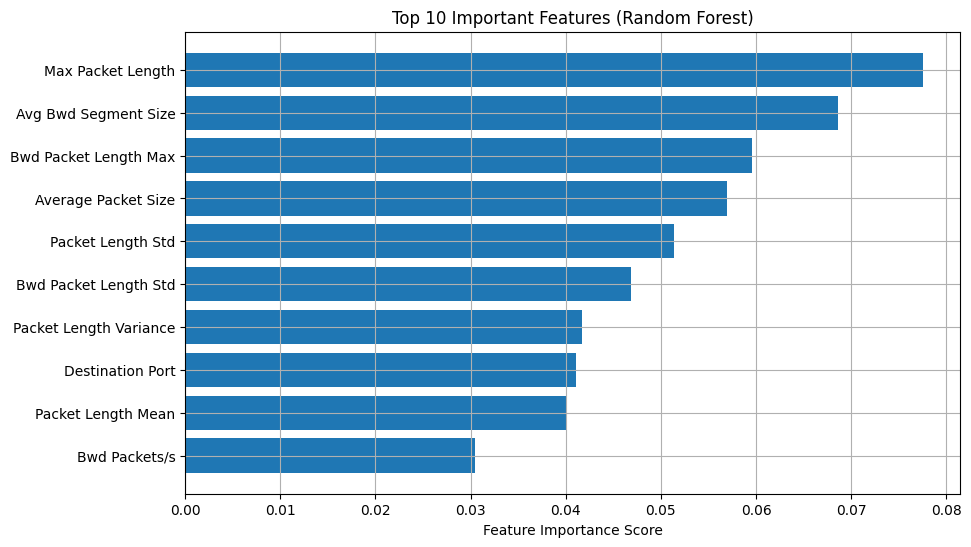

In [ ]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[-10:][::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Reshape for CNN input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define CNN model
cnn = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # 5 classes
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
start_cnn = time.time()
cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_split=0.1)
end_cnn = time.time()
print(f"CNN training time: {end_cnn - start_cnn:.2f} seconds")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7779/7779 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - accuracy: 0.9732 - loss: 0.0825 - val_accuracy: 0.9896 - val_loss: 0.0292
Epoch 2/10
7779/7779 ━━━━━━━━━━━━━━━━━━━━ 85s 10ms/step - accuracy: 0.9886 - loss: 0.0337 - val_accuracy: 0.9899 - val_loss: 0.0281
Epoch 3/10
7779/7779 ━━━━━━━━━━━━━━━━━━━━ 78s 10ms/step - accuracy: 0.9901 - loss: 0.0287 - val_accuracy: 0.9907 - val_loss: 0.0264
Epoch 4/10
7779/7779 ━━━━━━━━━━━━━━━━━━━━ 76s 9ms/step - accuracy: 0.9906 - loss: 0.0295 - val_accuracy: 0.9911 - val_loss: 0.0231
Epoch 5/10
7779/7779 ━━━━━━━━━━━━━━━━━━━━ 74s 9ms/step - accuracy: 0.9913 - loss: 0.0252 - val_accuracy: 0.9907 - val_loss: 0.0229
Epoch 6/10
7779/7779 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - accuracy: 0.9917 - loss: 0.0243 - val_accuracy: 0.9941 - val_loss: 0.0209
Epoch 7/10
7779/7779 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9925 - loss: 0.0237 - val_accuracy: 0.9912 - val_loss: 0.0205
Epoch 8/10
7779/7779 ━━━━━━━━━━━━━━━━━━━━ 72s 9ms/step - accuracy: 0.9931 - loss

In [ ]:
cnn_preds = cnn.predict(X_test_cnn)
cnn_pred_classes = np.argmax(cnn_preds, axis=1)
evaluate_model("CNN", y_test, cnn_pred_classes)


4322/4322 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step

CNN Results:
Confusion Matrix:
 [[87431    22   430    37    16]
 [    0  2040    18     1     0]
 [   28     0 45997     0     0]
 [    3     2     0  1086     9]
 [    6     1     2    13  1137]]
Classification Report:
                   precision    recall  f1-score   support

          BENIGN       1.00      0.99      1.00     87936
   DoS GoldenEye       0.99      0.99      0.99      2059
        DoS Hulk       0.99      1.00      0.99     46025
DoS Slowhttptest       0.96      0.99      0.97      1100
   DoS slowloris       0.98      0.98      0.98      1159

        accuracy                           1.00    138279
       macro avg       0.98      0.99      0.99    138279
    weighted avg       1.00      1.00      1.00    138279



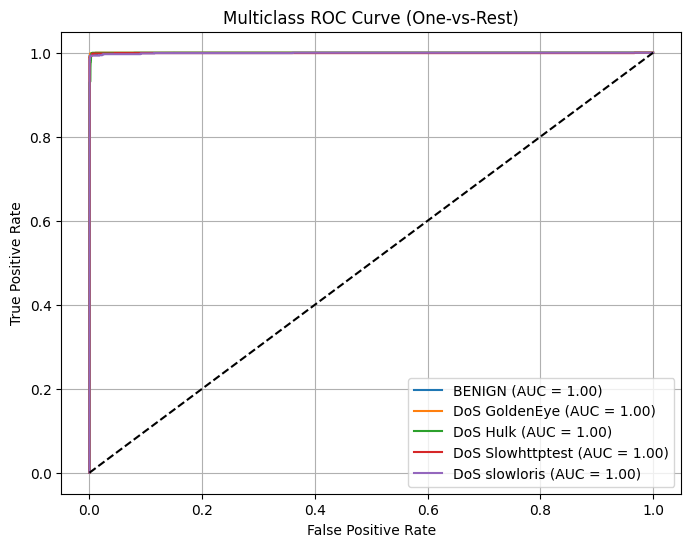

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 1. Binarize labels for multiclass ROC
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# cnn_preds is already softmax output (shape: [n_samples, n_classes])
fpr = dict()
tpr = dict()
roc_auc = dict()

# 2. Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], cnn_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

